track_id успешно преобразован в float.

Первые строки датасета:
    Unnamed: 0  track_id                 artists  \
0           0  627200.0             Gen Hoshino   
1           1   11904.0            Ben Woodward   
2           2  904256.0  Ingrid Michaelson;ZAYN   
3           3  218560.0            Kina Grannis   
4           4  328576.0        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falli

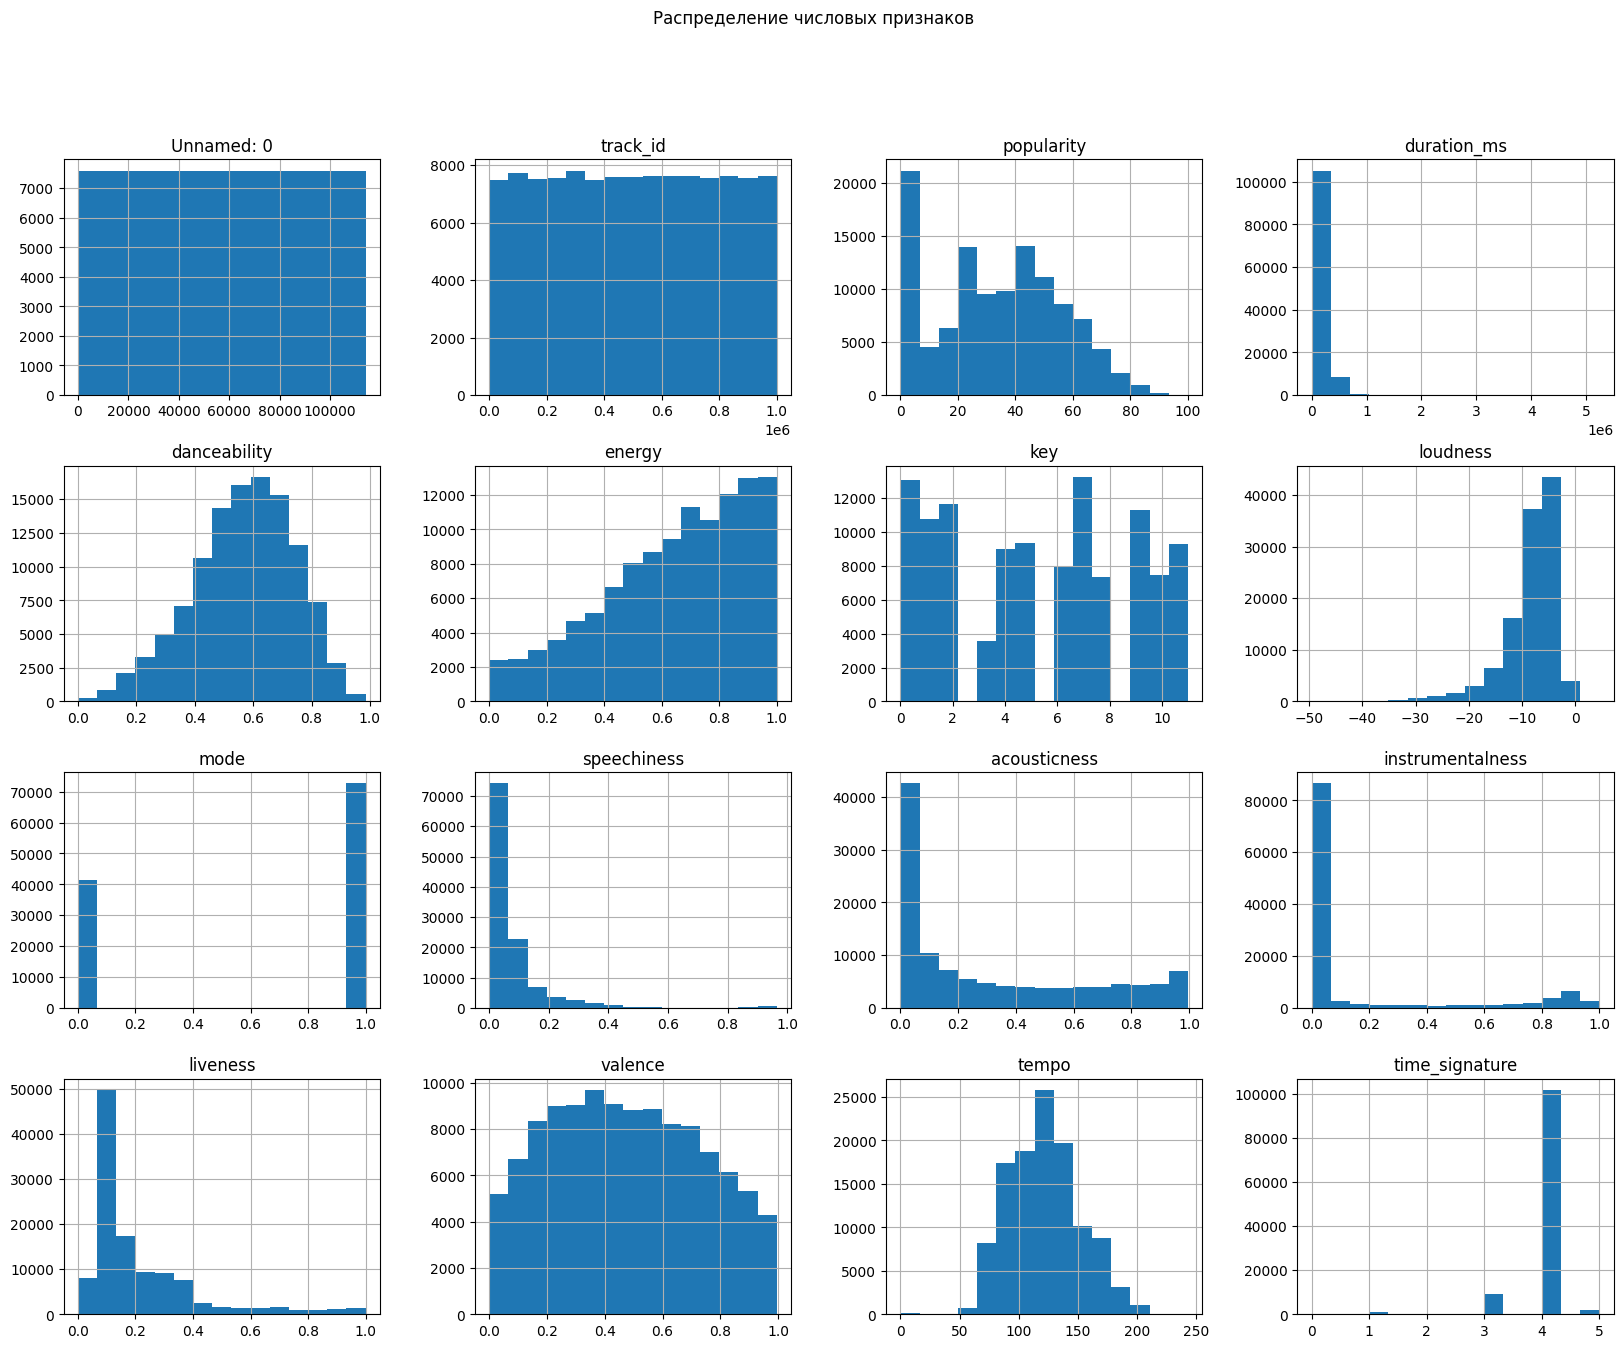


Корреляция новых признаков с target:
target              1.000000
loudness            0.050423
explicit            0.044082
album_name          0.042478
danceability        0.035448
track_genre         0.032692
Unnamed: 0          0.032142
time_signature      0.031073
tempo               0.013205
track_name          0.011914
track_id            0.004691
artists             0.003614
energy              0.001056
key                -0.003853
liveness           -0.005387
duration_ms        -0.007101
mode               -0.013931
acousticness       -0.025472
valence            -0.040534
speechiness        -0.044927
instrumentalness   -0.095139
Name: target, dtype: float64

Линейная регрессия:
RMSE: 21.9049
R2: 0.0277
Linear Regression: Среднее R2 = 0.0287 (+/- 0.0028)
Random Forest: Среднее R2 = 0.5808 (+/- 0.0032)
Gradient Boosting: Среднее R2 = 0.2372 (+/- 0.0030)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network: Среднее R2 = 0.1869 (+/- 0.0055)

Лучшая модель: Random Forest


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Загрузка данных
data_path = '/kaggle/input/spotify1234/dataset.csv'
data = pd.read_csv(data_path)

# Перезапись track_id в float
if 'track_id' in data.columns:
    try:
        data['track_id'] = data['track_id'].apply(lambda x: float(hash(x) % 1e6))
        print("track_id успешно преобразован в float.")
    except Exception as e:
        print(f"Ошибка преобразования track_id: {e}")

# Первичный осмотр данных
print("\nПервые строки датасета:\n", data.head())
print("\nИнформация о датасете:\n")
data.info()
print("\nОписание числовых признаков:\n", data.describe())

# Проверка на пропуски
def check_missing(data):
    missing = data.isnull().sum()
    print("\nПропуски в данных:")
    print(missing[missing > 0])

check_missing(data)

# EDA: Гистограммы распределения признаков
def plot_distributions(data):
    numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
    data[numerical_features].hist(bins=15, figsize=(20, 15))
    plt.suptitle('Распределение числовых признаков')
    plt.show()

plot_distributions(data)

# Выделение целевой переменной и признаков
def prepare_features(data):
    target_column = 'popularity'
    if target_column not in data.columns:
        raise ValueError(f"Не найдена колонка с именем '{target_column}'. Задайте корректное имя целевой переменной.")

    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Закодируем категориальные переменные
    for column in X.select_dtypes(include=['object']).columns:
        try:
            X[column] = LabelEncoder().fit_transform(X[column].astype(str))
        except Exception as e:
            print(f"Ошибка преобразования столбца {column}: {e}")

    return X, y

X, y = prepare_features(data)

# Обработка пропусков в данных
def handle_missing_data(X):
    for column in X.columns:
        if X[column].isnull().sum() > 0:
            if X[column].dtype in ['float64', 'int64']:
                X[column].fillna(X[column].mean(), inplace=True)
            else:
                X[column].fillna(X[column].mode()[0], inplace=True)
    return X

X = handle_missing_data(X)

# Корреляционная матрица новых колонок с целевой переменной
def correlation_with_target(X, y):
    augmented_data = X.copy()
    augmented_data['target'] = y
    correlation_matrix = augmented_data.corr()
    print("\nКорреляция новых признаков с target:")
    print(correlation_matrix['target'].sort_values(ascending=False))

correlation_with_target(X, y)

# Деление на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Простая модель: Линейная регрессия
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Оценка модели
predictions = lr.predict(X_test_scaled)
print("\nЛинейная регрессия:")
print(f"RMSE: {mean_squared_error(y_test, predictions, squared=False):.4f}")
print(f"R2: {r2_score(y_test, predictions):.4f}")

# Feature Engineering: добавление новых признаков
def add_new_features(data):
    data['feature_sum'] = data.sum(axis=1)  # Пример нового признака
    data['feature_mean'] = data.mean(axis=1)
    data['feature_std'] = data.std(axis=1)  # Новый признак: стандартное отклонение
    data['feature_max_min_diff'] = data.max(axis=1) - data.min(axis=1)  # Новый признак: разница между макс и мин
    return data

X = add_new_features(X)

# Модели: эксперименты
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

linear_regression_scores = cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=kfold, scoring='r2')
print(f"Linear Regression: Среднее R2 = {linear_regression_scores.mean():.4f} (+/- {linear_regression_scores.std():.4f})")

random_forest_scores = cross_val_score(RandomForestRegressor(random_state=42), X_train_scaled, y_train, cv=kfold, scoring='r2')
print(f"Random Forest: Среднее R2 = {random_forest_scores.mean():.4f} (+/- {random_forest_scores.std():.4f})")

gb_scores = cross_val_score(GradientBoostingRegressor(random_state=42), X_train_scaled, y_train, cv=kfold, scoring='r2')
print(f"Gradient Boosting: Среднее R2 = {gb_scores.mean():.4f} (+/- {gb_scores.std():.4f})")

nn_scores = cross_val_score(MLPRegressor(random_state=42, max_iter=500), X_train_scaled, y_train, cv=kfold, scoring='r2')
print(f"Neural Network: Среднее R2 = {nn_scores.mean():.4f} (+/- {nn_scores.std():.4f})")

# Вывод лучших моделей
results = {
    'Linear Regression': linear_regression_scores.mean(),
    'Random Forest': random_forest_scores.mean(),
    'Gradient Boosting': gb_scores.mean(),
    'Neural Network': nn_scores.mean()
}

best_model_name = max(results, key=results.get)
print("\nЛучшая модель:", best_model_name)
ц

Линейная регрессия:
RMSE: 21.9049
R2: 0.0277
Linear Regression: Среднее R2 = 0.0287 (+/- 0.0028)
Random Forest: Среднее R2 = 0.5808 (+/- 0.0032)
Gradient Boosting: Среднее R2 = 0.2372 (+/- 0.
Neural Network: Среднее R2 = 0.1869 (+/- 0.0055)

Лучшая модель: Random Fore

Neural Network: выдает ошибку поэтому немогу сделать лучше результат тк для хоть какого то результата надо останавливать выполнение.st0030)